Import packages enabling an import of a jupyter notebook as a package

In [17]:
from __future__ import print_function
import io
import os
import sys
import types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

Code enabling import of a jupyter notebook as a package

In [18]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

find_notebook('modelsconfig')
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

nbpackage = NotebookLoader()
nbpackage.load_module('modelsconfig')

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

nbpackage = NotebookFinder()
nbpackage.find_module('modelsconfig')

sys.meta_path.append(NotebookFinder())

importing Jupyter notebook from modelsconfig.ipynb


Import packages for building maps from NOMADS OpenDAP Server

In [19]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap, interp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import netCDF4
from netCDF4 import num2date
from dateutil import parser, tz
from datetime import datetime
from ncdump import ncdump
from subprocess import call
import modelsconfig

Enter model parameters (initialization date, time, and domain)

In [20]:
datetoday = datetime.utcnow().strftime('%Y%m%d')
mydate = str(raw_input('Enter YYYYMMDD: ')) or datetoday
cycle = str(raw_input('Enter UTC time: '))
select_model = 'hrrr'
varTitle, varName, clevs, varContours, legendLabel = modelsconfig.Maps.reflectivity()
lower_lat, upper_lat, left_lon, right_lon = modelsconfig.Maps.local()
centerpt_lat, centerpt_lon, mapwidth, mapheight = modelsconfig.mapdims(
    lower_lat, upper_lat, left_lon, right_lon)
file = modelsconfig.getmodel(select_model, mydate, cycle)

Enter YYYYMMDD: 
Enter UTC time: 08
Retrieving file...
URL: http://nomads.ncep.noaa.gov:9090/dods/hrrr/hrrr20170612/hrrr_sfc_08z


Create a directory on locally for graphics if one does not exist

In [21]:
if not os.path.exists(select_model):
    os.makedirs(select_model)

Extract variables from NETCDF file
Count the number of timesteps
Convert valid times to UTC and local time

In [22]:
print('File opened successfully! Processing data...')
lats, lons, lower_lat_idx, upper_lat_idx, left_lon_idx, \
right_lon_idx = modelsconfig.mapindex(
    file, lower_lat, upper_lat, left_lon, right_lon)
timesteps, validtimes = modelsconfig.gettimes(file)

File opened successfully! Processing data...


Build each map

Creating image 10 ...
Finished creating image 10


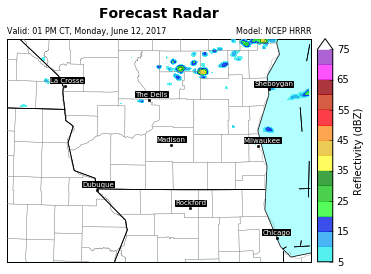

Creating image 11 ...
Finished creating image 11


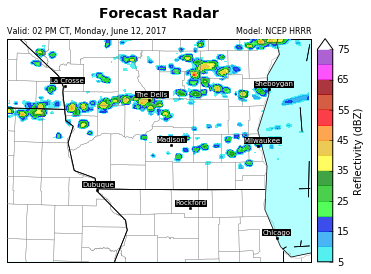

Creating image 12 ...
Finished creating image 12


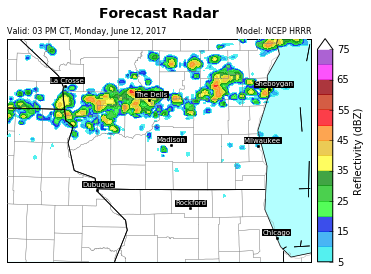

Creating image 13 ...
Finished creating image 13


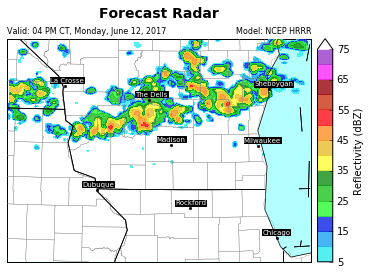

Creating image 14 ...
Finished creating image 14


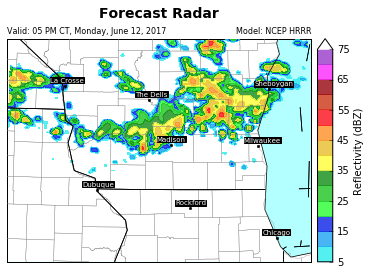

Creating image 15 ...
Finished creating image 15


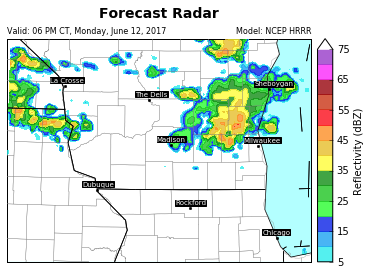

Creating image 16 ...
Finished creating image 16


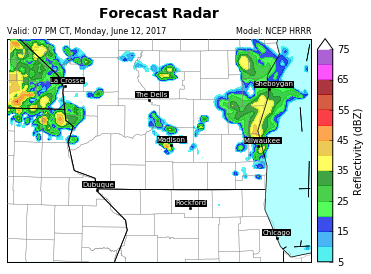

Creating image 17 ...
Finished creating image 17


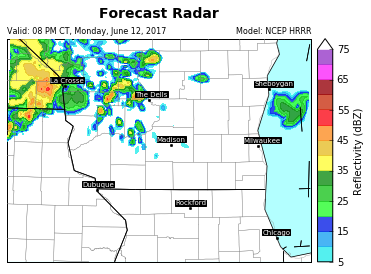

Creating image 18 ...
Finished creating image 18


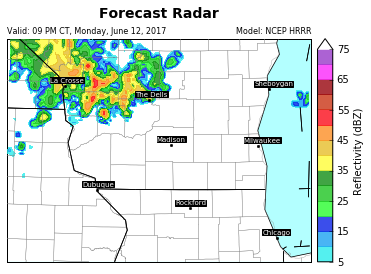

In [23]:
# For an accumulator
#init = file.variables['apcpsfc'][0, lower_lat_idx:upper_lat_idx, 
#                                 left_lon_idx:right_lon_idx]

for i in range(0, timesteps + 1):
    print('Creating image', i, '...')
    var = file.variables[varName][i, lower_lat_idx:upper_lat_idx,
                                  left_lon_idx:right_lon_idx]
    
    u = file.variables['ugrd10m'][i, lower_lat_idx:upper_lat_idx,
                                  left_lon_idx:right_lon_idx]
    v = file.variables['vgrd10m'][i, lower_lat_idx:upper_lat_idx,
                                  left_lon_idx:right_lon_idx]
    mag = np.sqrt(u**2 + v**2)
    
    if varName == 'gustsfc':
        var = var*2.237
    
    plt.figure()
    
    m = Basemap(width=mapwidth, height=mapheight, \
                rsphere=(6378137.00,6356752.3142), \
                resolution='l', area_thresh=1000., projection='lcc', \
                lat_1=lower_lat, lat_2=upper_lat, \
                lat_0=centerpt_lat, lon_0=centerpt_lon)
    
    x, y = m(*np.meshgrid(lons, lats))
    contour = m.contourf(x, y, var, clevs, colors=varContours,
    zorder=4,alpha=.8,extend='max')
    
    cbar = m.colorbar(location='right')
    cbar.ax.set_ylabel(legendLabel)
    cbar.ax.tick_params(labelsize=10)
    
    #xx, yy = m.makegrid(v.shape[1], v.shape[0], returnxy=True)[2:4]
    #streamlines = plt.streamplot(xx, yy, u, v, linewidth=0.5, arrowsize=3, zorder=6)
    
    m.drawcoastlines(linewidth=0.75, zorder=5)
    m.fillcontinents(color='white', lake_color='#b3ffff')
    m.drawcountries(linewidth=1.0, zorder=7)
    m.drawstates(linewidth=0.75, zorder=6)
    m.drawcounties(linewidth=0.3, color='gray', zorder=5)
    m.drawmapboundary(fill_color='#b3ffff')
    
    cityLons = [-89.40,-87.91,-89.09,-87.63,-91.24,-90.66,-89.77,-87.71]
    cityLats = [43.07,43.04,42.27,41.88,43.80,42.50,43.63,43.75]
    xLons, yLats = m(cityLons, cityLats)
    m.plot(xLons, yLats, 'k.', markersize=5, zorder=20)
    labels = ['Madison','Milwaukee','Rockford','Chicago','La Crosse','Dubuque',
              'The Dells','Sheboygan']
    for label, xpt, ypt in zip(labels, xLons, yLats):
        plt.text(xpt - 20000, ypt + 5000, label, fontsize=7, zorder=20, color='white',
                bbox = {'facecolor':'black', 'pad':0})
    
    mainTitle = '{}\n'.format(varTitle)
    lfTitle = '\nValid: {}'.format(validtimes[i])
    rtTitle = '\nModel: NCEP {}'.format(str.upper(select_model))
    imgDir = '{0}/{0}{1}.png'.format(select_model, str(i).zfill(2))
    
    plt.title('{}'.format(mainTitle), fontsize=14, fontweight='bold')
    plt.title('{}'.format(lfTitle), fontsize=8, loc='left')
    plt.title('{}'.format(rtTitle), fontsize=8, loc='right')
    plt.savefig('{}'.format(imgDir), dpi=300, bbox_inches='tight')
    
    print('Finished creating image', i)
    plt.show()
    plt.close()

Make animated GIF and MP4

In [24]:
modelsconfig.animated_gif(select_model, i)
modelsconfig.mp4(select_model)

Creating animated GIF
Finished creating animated GIF
Creating MP4
Finished creating MP4
